In [4]:
import tensorflow as tf
import numpy as np
import pretty_midi as midi
import os
import fluidsynth
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import time
import pandas as pd

In [8]:
#midi_data is a list of PrettyMIDI objects
midi_data = []
directory = "../data/"

for filename in os.listdir(directory):
    midi_data.append(midi.PrettyMIDI(os.path.join(directory, filename)))
    

In [43]:
#Pull notes from midi file
velocities = []
pitches = []
starts = []
ends = []
durations = []
steps = []
#Iterate through all midi objects, pull notes and zip together in a list 
for midi_obj in midi_data:
    piano = sorted(midi_obj.instruments[0].notes, key = lambda note: note.start)
    prev_start = piano[0].start
    for note in piano:
        velocities.append(note.velocity)
        pitches.append(note.pitch)
        starts.append(note.start)
        ends.append(note.end)
        durations.append(note.get_duration())
        steps.append(note.start - prev_start)
        prev_start = note.start


note_data_lists = list(zip(velocities, pitches, starts, ends, durations, steps))

#Move zipped lists into dataframe and sort by start time so notes are chronological 
note_data = pd.DataFrame(note_data_lists, columns = ['Velocities', 'Pitches', 'Starts', 'Ends', 'Durations', 'Steps'])
note_data = note_data.drop('Starts', axis = 1)
note_data = note_data.drop('Ends', axis = 1)
numpy_note_data = note_data.to_numpy()
numpy_note_data.shape[1]



4

In [42]:
len(numpy_note_data)

22297

In [25]:
pitches = 128
num_features = 4

In [26]:
init_dataset = tf.data.Dataset.from_tensor_slices(train_data)
init_dataset.element_spec

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-09-22 11:40:21.619645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-22 11:40:21.621034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorSpec(shape=(4,), dtype=tf.float64, name=None)

In [27]:
seq_length = 25
windows = init_dataset.window(seq_length + 1, shift = 1, stride = 1, drop_remainder = True)
type(windows)

tensorflow.python.data.ops.dataset_ops.WindowDataset

In [20]:
print(windows.element_spec)
window_elem = list(windows)[0]
print(len(window_elem))

DatasetSpec(TensorSpec(shape=(4,), dtype=tf.float64, name=None), TensorShape([]))
26


In [29]:
map_func = lambda x : x.batch(seq_length + 1, drop_remainder = True)

In [32]:
flattened_init_dataset = windows.flat_map(map_func)
type(flattened_init_dataset)

tensorflow.python.data.ops.dataset_ops.FlatMapDataset

In [33]:
def label_make(x):
    input_data = x[:-1]
    label_value = x[-1]
    label_dict = {
        key:label_value[i] for i,key in enumerate(['velocity', 'pitch', 'duration', 'step'])
    }
    input_data = input_data / [128, 128, 1, 1] #Normalization
    return input_data, label_dict


In [34]:
nonbatched_indata = flattened_init_dataset.map(label_make, num_parallel_calls = tf.data.AUTOTUNE)


In [35]:
batch_size = 64
#Shuffle populates a buffer of defined size with dataset and randomly samples it to shuffle examples 
#Batch takes dataset and divides into batches of specified size 
#Cache, assuming complete iteration of dataset, will cache the values and use cached data for further iteration 
#Prefetch allows for faster processing of data by preprocessing future elements while simultaneously processing currnet 
    # - Autotune parameter allows tensorflow to dynamically adjust buffer size for prefetch  as necessary
batched_indata = (nonbatched_indata
                    .shuffle(len(note_data) - seq_length)
                    .batch(batch_size, drop_remainder = True)
                    .cache()
                    .prefetch(tf.data.AUTOTUNE)
                )

type(batched_indata)


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

numpy.ndarray

In [37]:
#Build LSTM network with Keras Functional API
input_shape = (seq_length, 4)
alpha = 0.003

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)


outputs = {
    'velocity': tf.keras.layers.Dense(128, name = 'velocity')(x),
    'pitch': tf.keras.layers.Dense(128, name = 'pitch')(x),
    'duration': tf.keras.layers.Dense(1, name = 'duration')(x),
    'step': tf.keras.layers.Dense(1, name = 'step')(x)
}

loss = {
    'velocity': tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    'duration': tf.keras.losses.MeanSquaredLogarithmicError(),
    'step': tf.keras.losses.MeanSquaredError()
}

model = tf.keras.Model(inputs, outputs, name = 'Chad')

model.compile(
            loss = loss, 
            loss_weights = {
                'velocity': 1,
                'pitch': 1,
                'duration': 0.5,
                'step': 1
            },
            optimizer = tf.keras.optimizers.Adam(learning_rate = alpha),
            metrics = ['accuracy']
        )
        
model.summary()


Model: "Chad"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          68096       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                               

In [38]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [39]:
type(model)


keras.engine.functional.Functional

In [72]:
history = model.fit(
    batched_indata,
    epochs = 100,
    callbacks = callbacks
)


Epoch 1/100
348/348 [==============================] - 6s 17ms/step - loss: 8.0516 - duration_loss: 0.4609 - pitch_loss: 3.6549 - step_loss: 0.0530 - velocity_loss: 4.1132
Epoch 2/100
348/348 [==============================] - 6s 17ms/step - loss: 8.0069 - duration_loss: 0.3827 - pitch_loss: 3.6522 - step_loss: 0.0530 - velocity_loss: 4.1103
Epoch 3/100
348/348 [==============================] - 6s 17ms/step - loss: 7.9685 - duration_loss: 0.3276 - pitch_loss: 3.6483 - step_loss: 0.0531 - velocity_loss: 4.1033
Epoch 4/100
348/348 [==============================] - 6s 17ms/step - loss: 7.9210 - duration_loss: 0.2644 - pitch_loss: 3.6452 - step_loss: 0.0526 - velocity_loss: 4.0910
Epoch 5/100
348/348 [==============================] - 6s 17ms/step - loss: 7.8667 - duration_loss: 0.2190 - pitch_loss: 3.6418 - step_loss: 0.0530 - velocity_loss: 4.0625
Epoch 6/100
348/348 [==============================] - 6s 16ms/step - loss: 7.7934 - duration_loss: 0.1952 - pitch_loss: 3.6351 - step_loss:

In [40]:
type(history)

NameError: name 'history' is not defined

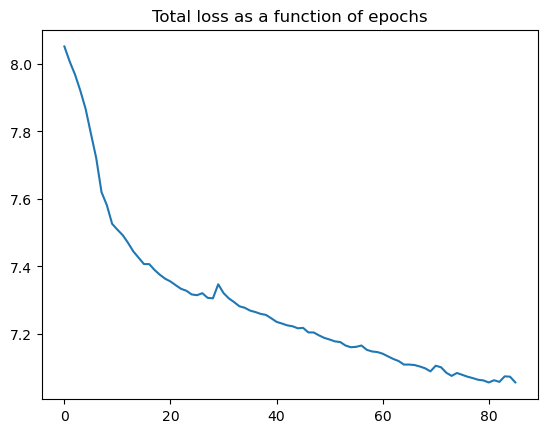

In [75]:
plt.plot(history.epoch, history.history['loss'], label = 'Total Loss')
plt.title('Total loss as a function of epochs')
plt.show()

In [110]:
def predict_note(notes: np.array, model: tf.keras.Model, temperature: int) -> int:

    assert temperature > 0
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    velocity_logits = predictions['velocity']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    velocity_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples = 1)
    velocity = tf.random.categorical(velocity_logits, num_samples = 1)
    velocity = tf.squeeze(velocity, axis = -1)
    pitch = tf.squeeze(pitch, axis = -1) 
    step = tf.squeeze(step, axis = -1)
    duration = tf.squeeze(duration, axis = -1)

    return int(velocity), int(pitch),  float(step), float(duration)


In [117]:
def note_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str) -> midi.PrettyMIDI:
    ret_obj = midi.PrettyMIDI()
    instrument = midi.Instrument(midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(note['step']+ prev_start)
        end = float(start + note['duration'])
        note = midi.Note(
            velocity = int(note['velocity']),
            pitch = int(note['pitch']),
            start = start,
            end = end
        )
        instrument.notes.append(note)
        prev_start = start 
    
    ret_obj.instruments.append(instrument)
    ret_obj.write(out_file)
    return ret_obj 


In [44]:
temperature = 2
num_predictions = 120 
starter_notes = train_data[:seq_length][:]

starter_notes_normed = starter_notes / np.array([128, 128, 1,1])
composition = [] 
prev_start = 0
for _ in range(num_predictions):
    velocity, pitch, step, duration = predict_note(starter_notes_normed, model, temperature) #Get predicted note from model 
    start = prev_start + step 
    end = start + duration 
    input_note = (velocity, pitch, step, duration) #Store note value as a tuple
    composition.append((*input_note, start, end)) #Append unpacked tuple, start and end data to composition list 
    np.delete(starter_notes_normed, 0, axis = 0) #Remove the first note of the sequence 
    np.append(starter_notes_normed, np.expand_dims(input_note, 0), axis = 0) #Append the newly predicted note to recycle 
    prev_start = start 


composition = pd.DataFrame(composition, columns = ['velocity', 'pitch', 'step', 'duration', 'start', 'end'])

type(starter_notes)

NameError: name 'predict_note' is not defined

In [118]:
write_file = "firstPiece.midi"
final_product = note_to_midi(composition, write_file, instrument_name = "Acoustic Grand Piano")